# Redes Neurais Recorrentes

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

%matplotlib inline

/Users/marcocristo/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
def plot_figs(lst):
    if len(lst) == 1:
        plt.matshow(lst[0], cmap = 'gray', interpolation='nearest')
    else:
        f, axes = plt.subplots(1, len(lst))
        for i, a in enumerate(axes):
            a.matshow(lst[i], cmap = 'gray', interpolation='nearest')
            a.set(aspect='equal')

### Uma RNN manual

RNN - Recurrent Neural Networks são redes neurais em que os neurônios tem como entrada a sua saída. Desta forma, eles podem formar memórias.

Na prática, elas são implementadas como uma arquitetura copiada múltiplas vezes. Há tantas cópias quantas são os instantes de tempo representados no treino. A saída de cada cópia é entrada para a próxima cópia. O exemplo abaixo descreve uma RNN com 3 neurônios de entrada e cinco de saída em uma célula RNN (ou seja, em um instante do tempo). Supondo que temos treinos com 2 instantes de tempo, a rede teria duas céculas, como no diagrama abaixo: 

<img src="images/rnn0.png" alt="Exemplo de RNN" style="width: 600px;"/>

Esta rede pode ser representada da seguinte forma em tensorflow: 

In [ ]:
reset_graph()

n_inputs = 3
n_neurons = 5

X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])

Wx = tf.Variable(tf.random_normal(shape=[n_inputs, n_neurons], dtype=tf.float32))
Wy = tf.Variable(tf.random_normal(shape=[n_neurons,n_neurons], dtype=tf.float32))
b = tf.Variable(tf.zeros([1, n_neurons], dtype=tf.float32))

Y0 = tf.tanh(tf.matmul(X0, Wx) + b)
Y1 = tf.tanh(tf.matmul(Y0, Wy) + tf.matmul(X1, Wx) + b)

init = tf.global_variables_initializer()

In [ ]:
# t = 0
X0_batch = np.array([[0.0, 0.1, 0.2],   # instance 0
                     [0.3, 0.4, 0.5],   # instance 1
                     [0.6, 0.7, 0.8],   # instance 2
                     [0.9, 1.0, 1.1]])  # instance 3
# t = 1
X1_batch = np.array([[1.1, 1.2, 1.3], 
                     [1.4, 1.5, 1.6], 
                     [1.7, 1.8, 1.9], 
                     [2.0, 2.1, 2.2]]) 

with tf.Session() as sess:
    init.run()
    Y0_val, Y1_val = sess.run([Y0, Y1], feed_dict={X0: X0_batch, X1: X1_batch})
    
print Y0_val
print Y1_val

A rede acima pode ser redefinida usando as funções `BasicRNNCell` e `static_rnn`. Note que neste caso, a função retorna tanto as saídas da rede quanto o estado final dela que, neste caso, corresponde a saída para o último intervalo de tempo (o mesmo que `Y1`).

In [ ]:
reset_graph()

n_inputs = 3
n_neurons = 5

X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
output_seqs, states = tf.contrib.rnn.static_rnn(basic_cell, [X0, X1],
                                                dtype=tf.float32)
Y0, Y1 = output_seqs

init = tf.global_variables_initializer()

In [ ]:
# t = 0
X0_batch = np.array([[0.0, 0.1, 0.2],   # instance 0
                     [0.3, 0.4, 0.5],   # instance 1
                     [0.6, 0.7, 0.8],   # instance 2
                     [0.9, 1.0, 1.1]])  # instance 3
# t = 1
X1_batch = np.array([[1.1, 1.2, 1.3], 
                     [1.4, 1.5, 1.6], 
                     [1.7, 1.8, 1.9], 
                     [2.0, 2.1, 2.2]]) 

with tf.Session() as sess:
    init.run()
    Y0_val, Y1_val = sess.run([Y0, Y1], feed_dict={X0: X0_batch, X1: X1_batch})
    
print Y0_val
print Y1_val

No último exemplo, ainda tivemos que criar uma entrada para cada instante de tempo. A seguir, vamos automatizar isso também:

In [ ]:
reset_graph()

n_inputs = 3
n_neurons = 5
n_steps = 2

In [ ]:
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
# get list of n_steps tensors with shape [None, n_inputs]
Xseqs = tf.unstack(tf.transpose(X, perm = [1, 0, 2]))

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
output_seqs, states = tf.contrib.rnn.static_rnn(basic_cell, Xseqs,
                                                dtype=tf.float32)
# merge outputs and get final shape (batches, steps, outputs)
outputs = tf.transpose(tf.stack(output_seqs), perm = [1, 0, 2])

In [ ]:
init = tf.global_variables_initializer()

In [ ]:
# t = 0
X_batch = np.array([[[0.0, 0.1, 0.2], [1.1, 1.2, 1.3]],   # instance 0
                    [[0.3, 0.4, 0.5], [1.4, 1.5, 1.6]],   # instance 1
                    [[0.6, 0.7, 0.8], [1.7, 1.8, 1.9]],   # instance 2
                    [[0.9, 1.0, 1.1], [2.0, 2.1, 2.2]]])  # instance 3

with tf.Session() as sess:
    init.run()
    out_vals = sess.run(outputs, feed_dict={X: X_batch})
    
print out_vals

### Desdobramento dinâmico no tempo

Na prática, contudo, o tensorflow pode poupar todo o trabalho de transposições e mudanças de formas necessárias antes, se usarmos `dynamic_rnn`. De fato, neste caso, o grafo com todas as células para todos instantes no tempo não é realmente criado. O algoritmo usa um laço e controla o processo de atualização de pesos sem consumir tanta memória.

In [ ]:
reset_graph()

n_inputs = 3
n_neurons = 5
n_steps = 2

In [ ]:
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

In [ ]:
init = tf.global_variables_initializer()

In [ ]:
# t = 0
X_batch = np.array([[[0.0, 0.1, 0.2], [1.1, 1.2, 1.3]],   # instance 0
                    [[0.3, 0.4, 0.5], [1.4, 1.5, 1.6]],   # instance 1
                    [[0.6, 0.7, 0.8], [1.7, 1.8, 1.9]],   # instance 2
                    [[0.9, 1.0, 1.1], [2.0, 2.1, 2.2]]])  # instance 3

with tf.Session() as sess:
    init.run()
    out_vals = sess.run(outputs, feed_dict={X: X_batch})
    
print out_vals

#### Manipulando sequências com tamanho variável

Em todos os exemplos acima, nossas entradas tinham o mesmo tamanho. Em muitos problemas, este não é o caso. Por exemplo, em classificação de tweets, cada tweet pode ter um tamanho variável.

In [ ]:
reset_graph()

n_inputs = 3
n_neurons = 5
n_steps = 2

Se a RNN vai receber sequências de tamanhos diferentes, é necessário informar a lista dos tamanhos:

In [ ]:
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
seq_lens = tf.placeholder(tf.float32, [None])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32,
                                   sequence_length = seq_lens)

In [ ]:
init = tf.global_variables_initializer()

E, na entrada, as sequências que tem tamanho menor _tem que ser dadas como zero (padding)_ nos intervalos de tempo que não irão aparecer. Por exemplo, supondo que em nosso exemplo anterior, a segunda instância fosse observada apenas no tempo 0 (sequência de tamanho 1), teríamos:

In [ ]:
# t = 0
X_batch = np.array([[[0.0, 0.1, 0.2], [1.1, 1.2, 1.3]],   # instance 0
                    [[0.3, 0.4, 0.5], [0, 0, 0]],         # instance 1 -- padding
                    [[0.6, 0.7, 0.8], [1.7, 1.8, 1.9]],   # instance 2
                    [[0.9, 1.0, 1.1], [2.0, 2.1, 2.2]]])  # instance 3

with tf.Session() as sess:
    init.run()
    out_vals, state_vals = sess.run([outputs, states], 
                        feed_dict={X: X_batch, seq_lens: [2,1,2,2]})
    
print out_vals

Note que as saídas para o tempo 2 para a segunda instância são zero. Além disso, observe que o estado final da segunda instância corresponde, de fato, ao seu valor no tempo 0:

In [ ]:
print state_vals

Para o caso em que a saída tem tamanho variável, o reconhecimento do fim prematuro será modelado na própria rede. Por exemplo, em tradução, a rede deve emitir uma frase com um número não previamente conhecido de palavras. Assim, a rede deve emitir cada palavra e, quando considerar pertinente, ela emite uma palavra especial que indica _fim de frase_. Ao analisar a saída da rede, são consideradas apenas as palavras observadas antes de _fim de frase_.

## Classificando MNIST

A ideia de classificar as imagens da MNIST usando uma RNN consiste em considerar que cada imagem é formada por uma sequência de linhas de pixels, cada linha vista em um instante de tempo. 

In [3]:
n_steps = 28
n_inputs = 28

In [4]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("data/MNIST_data")
X_test = mnist.test.images.reshape((-1, n_steps, n_inputs))
y_test = mnist.test.labels

Extracting data/MNIST_data/train-images-idx3-ubyte.gz
Extracting data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting data/MNIST_data/t10k-labels-idx1-ubyte.gz


Vamos construir uma rede em que cada célula RNN tem 150 neurônios. O estado final da RNN (um código com 150 valores) então será entrada para uma rede densa com dez neurônios agregados via softmax, como ilustrado abaixo (nós vermelhos com dimensão 28, verdes com dimensão 150 e azul com dimensão 10; 28 desdobramentos no tempo). 

<img src="images/rnn1.png" alt="Exemplo de RNN" style="width: 600px;"/>

In [ ]:
reset_graph()

n_neurons = 150
n_outputs = 10

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

logits = tf.layers.dense(states, n_outputs)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                          logits=logits)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
accuracy = tf.reduce_mean(tf.cast(tf.nn.in_top_k(logits, y, 1), 
                                  tf.float32))

init = tf.global_variables_initializer()

Vamos treinar a nossa rede usando batches de 150 instâncias: 

In [ ]:
n_epochs = 10
batch_size = 150

with tf.Session() as s:
    init.run()
    for e in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            s.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print '%d - accuracy tr: %.6f test: %.6f' % (e, acc_train, acc_test)

# Notas de aula, 9 de outubro

## Classificando MNIST com uma RNN de 2 camadas

<img src="images/rnn1multi.png" alt="Exemplo de RNN" style="width: 700px;"/>

In [5]:
reset_graph()

n_steps = 28
n_inputs = 28
n_outputs = 10
n_neurons = 100
n_layers = 2

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

# layers
layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons,
                                     activation=tf.nn.relu)
             for i in range(n_layers)]
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

# dense net
states_concat = tf.concat(values = states, axis = 1)
logits = tf.layers.dense(states_concat, n_outputs)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                          logits=logits)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
accuracy = tf.reduce_mean(tf.cast(tf.nn.in_top_k(logits, y, 1), 
                                  tf.float32))

init = tf.global_variables_initializer()

In [6]:
n_epochs = 10
batch_size = 150

with tf.Session() as s:
    init.run()
    for e in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            s.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print '%d - accuracy tr: %.6f test: %.6f' % (e, acc_train, acc_test)

0 - accuracy tr: 0.913333 test: 0.933900
1 - accuracy tr: 0.953333 test: 0.950300
2 - accuracy tr: 0.946667 test: 0.961500
3 - accuracy tr: 0.973333 test: 0.973500
4 - accuracy tr: 0.953333 test: 0.961500
5 - accuracy tr: 0.993333 test: 0.977700
6 - accuracy tr: 0.980000 test: 0.977800
7 - accuracy tr: 0.980000 test: 0.972700
8 - accuracy tr: 0.980000 test: 0.976500
9 - accuracy tr: 1.000000 test: 0.980700


## Prevendo séries de tempo
### Um modelo $n \times n$

In [7]:
def next_batch(df, batch_size, n_steps):
    st_points = random.sample(range(0, len(df) - n_steps), batch_size)
    s_train = np.asarray([df[st: st + n_steps].values.reshape((-1,1)) for st in st_points])
    s_test = np.asarray([df[st + 1: st + 1 + n_steps].values.reshape((-1,1)) for st in st_points])
    return (s_train, s_test)

In [8]:
def plot_series(y_test, y_pred, title = 'A test instance'):
    plt.title(title, fontsize=14)
    plt.plot(y_test, "-", markersize=10)
    plt.plot(y_test, "bo", markersize=10, label="real")
    plt.plot(y_pred, "-", markersize=10)
    plt.plot(y_pred, "w*", markersize=10, label="prediction")
    plt.legend(loc="upper left")
    plt.xlabel("Time")

In [9]:
import pandas as pd
import random
import matplotlib.pyplot as plt

%matplotlib inline

In [10]:
airline = pd.read_csv('data/airline.csv')

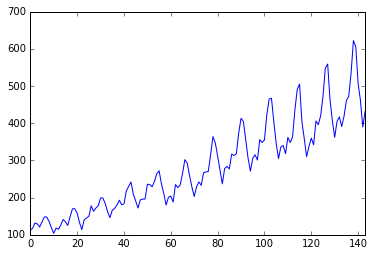

In [12]:
airline['passengers'].plot()

In [11]:
airline.head(5)

,passengers,date
0,112,1949-01-01
1,118,1949-02-01
2,132,1949-03-01
3,129,1949-04-01
4,121,1949-05-01


In [13]:
b = next_batch(airline['passengers'], 1, 6)

In [16]:
b[0].shape

(1, 6, 1)

In [17]:
print b[0][0,:,0]
print b[1][0,:,0]

[170 170 158 133 114 140]
[170 158 133 114 140 145]


In [30]:
reset_graph()

n_steps = 24
n_inputs = 1
n_outputs = 1
n_neurons = 50
learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

In [31]:
cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, 
                                   activation=tf.nn.relu)
collapsed_cell = tf.contrib.rnn.OutputProjectionWrapper(cell, 
                                                        output_size = n_outputs)

In [32]:
outputs, states = tf.nn.dynamic_rnn(collapsed_cell, X, dtype=tf.float32)

In [33]:
loss = tf.reduce_mean(tf.square(outputs - y)) # MSE
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [34]:
train_series = airline['passengers'][:-(n_steps + 1)]
test_series = airline['passengers'][-(n_steps + 1):]

In [35]:
train_mean = train_series.mean()
train_std = train_series.std()

In [36]:
train_series_n = (train_series - train_mean) / train_std
test_series_n = (test_series - train_mean) / train_std

In [37]:
n_iters = 1500
batch_size = 50

with tf.Session() as s:
    init.run()
    for iteration in range(n_iters):
        X_batch, y_batch = next_batch(train_series_n, batch_size, n_steps)
        s.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration%100 == 0:
            mse = loss.eval(feed_dict = {X: X_batch, y: y_batch})
            print '%5d - MSE: %.6f' % (iteration, mse)
    saver.save(s, '/tmp/stempo1')

    0 - MSE: 0.953224
  100 - MSE: 0.080722
  200 - MSE: 0.046411
  300 - MSE: 0.034148
  400 - MSE: 0.022119
  500 - MSE: 0.017126
  600 - MSE: 0.015362
  700 - MSE: 0.014859
  800 - MSE: 0.014413
  900 - MSE: 0.013654
 1000 - MSE: 0.013318
 1100 - MSE: 0.012795
 1200 - MSE: 0.011959
 1300 - MSE: 0.011638
 1400 - MSE: 0.012504


In [38]:
with tf.Session() as s:
    saver.restore(s, '/tmp/stempo1')
    X_test, y_test = next_batch(test_series_n, 1, n_steps)
    y_pred = s.run(outputs, feed_dict = {X: X_test})

INFO:tensorflow:Restoring parameters from /tmp/stempo1


In [40]:
y_pred.shape

(1, 24, 1)

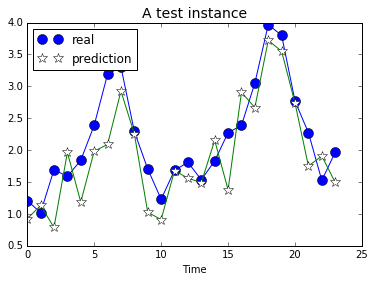

In [41]:
plot_series(y_test[0,:,0], y_pred[0,:,0])

In [42]:
y_test_f = (y_test[0,:,0] * train_std) + train_mean
y_pred_f = (y_pred[0,:,0] * train_std) + train_mean

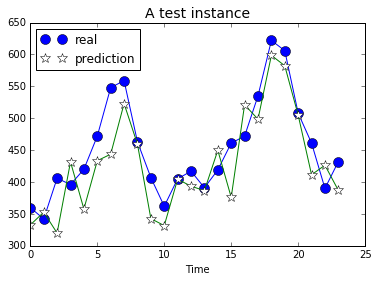

In [43]:
plot_series(y_test_f, y_pred_f)